**Human Connectome Project: resting state fMRI**

n_subjects: `812` (ages 22-35)  
n_timepoints: `4800` x 0.75s = 3600s = 60min  
n_regions: `15, 25, 50, 100, 300`  

regions defined by decomposing group-level ICA maps at various spatial scales

timeseries preprocessing:
1. highpass filtered
2. mean-centered
3. removal of phyiological + motion confounds using linear regression:  
    ICA noise components classified by FIX algorithm +   24 head motion parameters

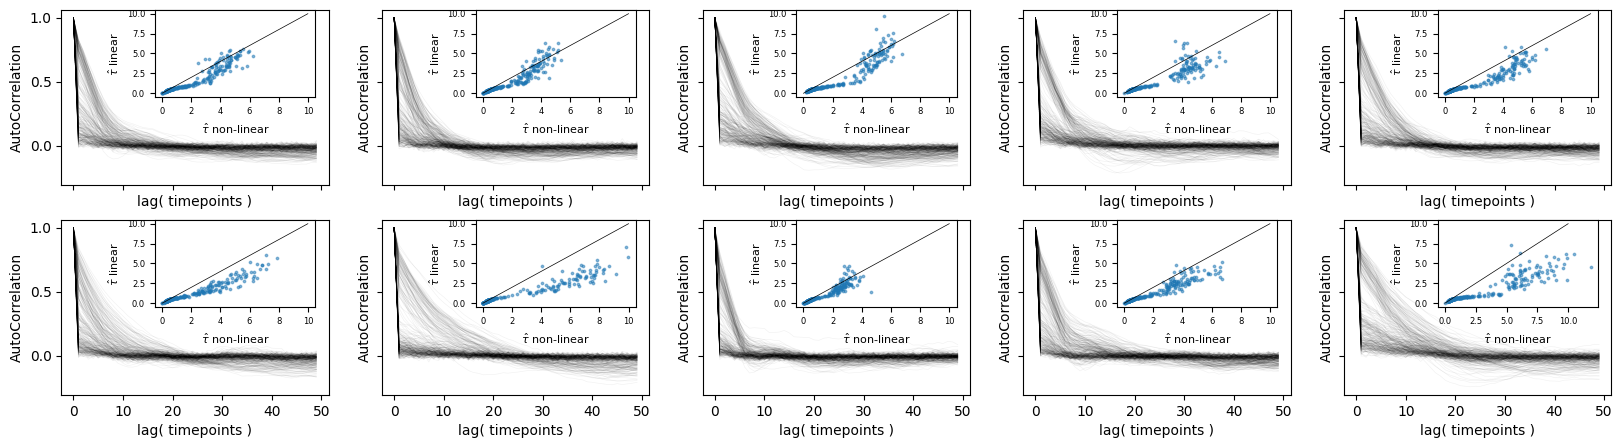

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neurodsp import spectral
from nilearn import plotting
from scipy.stats import linregress, sem
from scipy.optimize import curve_fit

from src import acf_utils


def f(x, tau):
    """exponential decay function for estimating ACF parameters"""
    return np.exp(-x / (tau if tau > 0 else 1e-9))


def calc_timescale_nlm(X_acf, n_timepoints):
    """calculate the timescale for each timeseries/region: using non-linear least squares (10X slower)"""
    x = np.arange(n_timepoints)
    curve_fit_kwargs = dict(bounds=(0, np.inf), ftol=1e-6)
    return np.array([curve_fit(f, x, y, **curve_fit_kwargs)[0].squeeze() for y in X_acf])


def calc_timescale_lm(X):
    """calculate the timescale for each timeseries/region: using linear least squares (10X faster)"""
    # timescale = -1 / ln(slope)
    slope_to_timescale = lambda lm: -1 / np.log(lm.slope if lm.slope > 0 else 1e-9)
    # stderr = (1 / (slope * ln(slope)^2)) * stderr
    delta_method = (
        lambda lm: (1 / (lm.slope * np.log(lm.slope if lm.slope > 0 else 1e-9) ** 2)) * lm.stderr
    )

    timescales, stderrs = [], []
    for region in X:  # loop over regions
        lm = linregress(region[:-1], region[1:])
        timescales.append(slope_to_timescale(lm))
        stderrs.append(delta_method(lm))
    return timescales, stderrs


n_subjects, n_regions, n_timepoints = 10, 300, 4800
sampling_rate = 1 / 0.75
hcp_coordinates = np.load("./data/nregions-300_coordinates.npy")
hcp_sizes = np.load("./data/nregions-300_sizes.npy")

Xs = np.load("./data/nsubjects-10_nregions-300_hcp.npy")

fig, axs = plt.subplots(2, 5, figsize=(20, 5), sharex=True, sharey=True)
axs = axs.flatten()

# !!! 25 sec runtime !!!
for X, ax in zip(Xs, axs):
    """plot the ACF per region + the distribution of timescales across regions"""

    X_acf = acf_utils.acf_fft(X, n_timepoints)
    X_timescale_nlm = calc_timescale_nlm(X_acf, n_timepoints)
    X_timescale_lm, _ = calc_timescale_lm(X)

    ax.plot(X_acf[:, :50].T, alpha=0.05, c="k", lw=0.5)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel("lag( timepoints )")
    ax.set_ylabel("AutoCorrelation")

    inset_ax = ax.inset_axes([0.35, 0.5, 0.6, 0.5])
    inset_ax.scatter(X_timescale_nlm, X_timescale_lm, s=3, alpha=0.5)
    inset_ax.plot([0, 10], [0, 10], c="k", lw=0.5)  # 1:1 line
    inset_ax.tick_params(axis="both", which="major", labelsize=6)
    inset_ax.set_xlabel(r"$\hat{\tau}$ non-linear", fontsize=8)
    inset_ax.set_ylabel(r"$\hat{\tau}$ linear", fontsize=8)


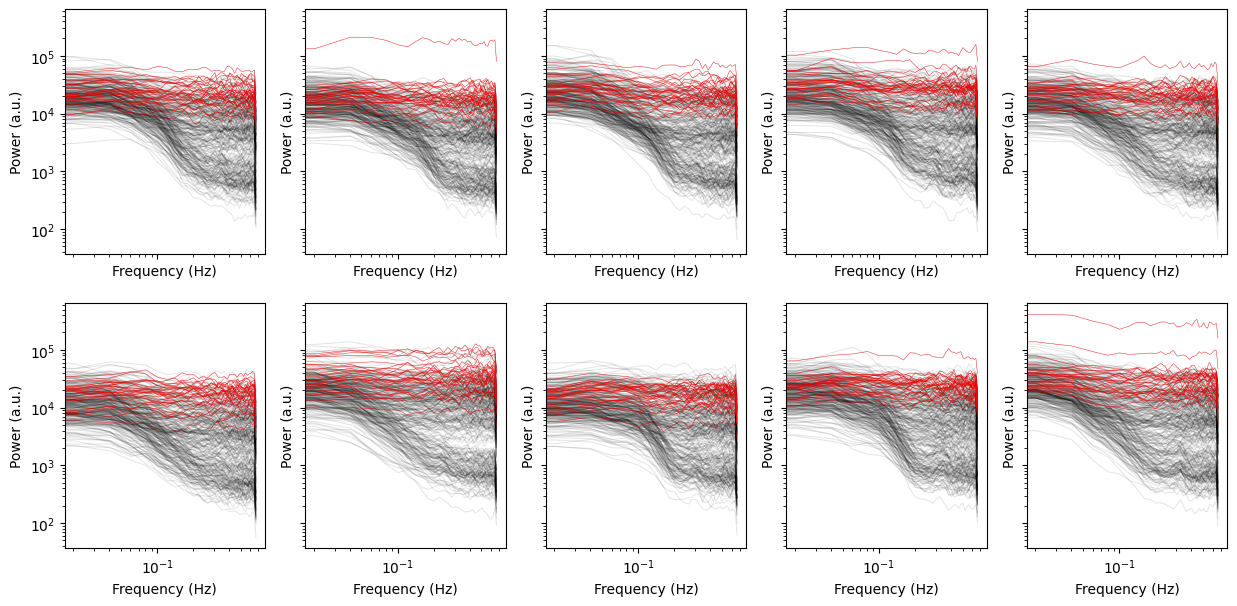

In [2]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True)
axs = axs.flatten()

outliers = np.zeros(n_regions)
for X, ax in zip(Xs, axs):
    """plot the PSD of the timeseries per region"""
    freqs, powers = spectral.compute_spectrum(X, sampling_rate, nperseg=int(sampling_rate * 50))

    # find the flattest 10% of PDSs
    x = np.log10(freqs[1:])
    n_select = int(0.1 * n_regions)
    slopes = [linregress(x, np.log10(power[1:])).slope for power in powers]
    idx = np.argsort(np.abs(slopes))[:n_select]
    outliers[idx] += 1

    ax.loglog(np.tile(freqs, (n_regions, 1)).T, powers.T, color="k", lw=0.75, alpha=0.1)
    ax.loglog(np.tile(freqs, (n_select, 1)).T, powers[idx].T, color="r", lw=0.25, alpha=1)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power (a.u.)")


**identify regions with flattest PSD**

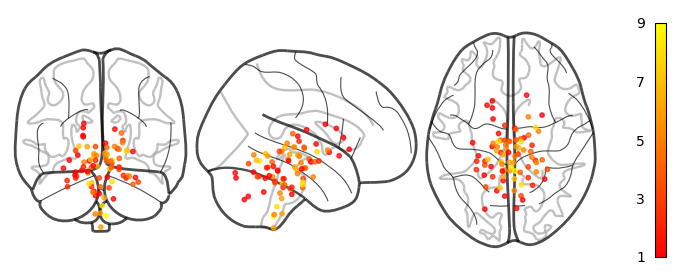

In [3]:
idx = np.where(outliers != 0)[0]
plotting.plot_markers(
    outliers[idx],
    hcp_coordinates[idx],
    node_cmap="autumn",
    alpha=0.75,
    node_size=10,
    annotate=False,
)


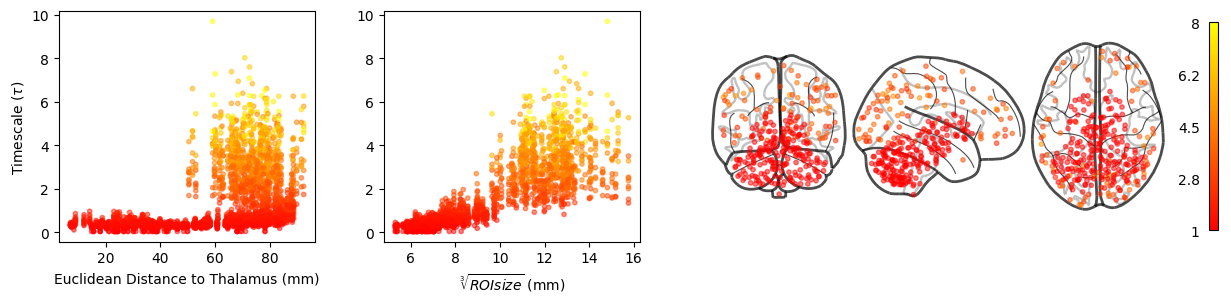

In [4]:
center = [0, -12, 4]  # thalamus coordinates

# euclidean distance to the thalamus (brain center)
distances = np.linalg.norm(hcp_coordinates - center, axis=1)

timescales, stderrs = zip(*[calc_timescale_lm(X) for X in Xs])

# plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw=dict(width_ratios=[0.5, 0.5, 1]))

for timescale in timescales:
    axs[0].scatter(distances, timescale, alpha=0.5, s=10, c=timescale, cmap="autumn")

axs[0].set_xlabel(f"Euclidean Distance to Thalamus (mm)")
axs[0].set_ylabel(r"Timescale ($\tau$)")

for timescale in timescales:
    axs[1].scatter(hcp_sizes, timescale, alpha=0.5, s=10, c=timescale, cmap="autumn")

axs[1].set_xlabel(r"$\sqrt[3]{ROIsize}$ (mm)")

plotting.plot_markers(
    np.mean(timescales, axis=0),
    hcp_coordinates,
    axes=axs[2],
    node_cmap="autumn",
    alpha=0.5,
    node_vmin=1,
    node_vmax=8,
    node_size=10,
    annotate=False,
)


**compare within vs between subject standard errors**

Text(0.5, 3.722222222222216, 'regions')

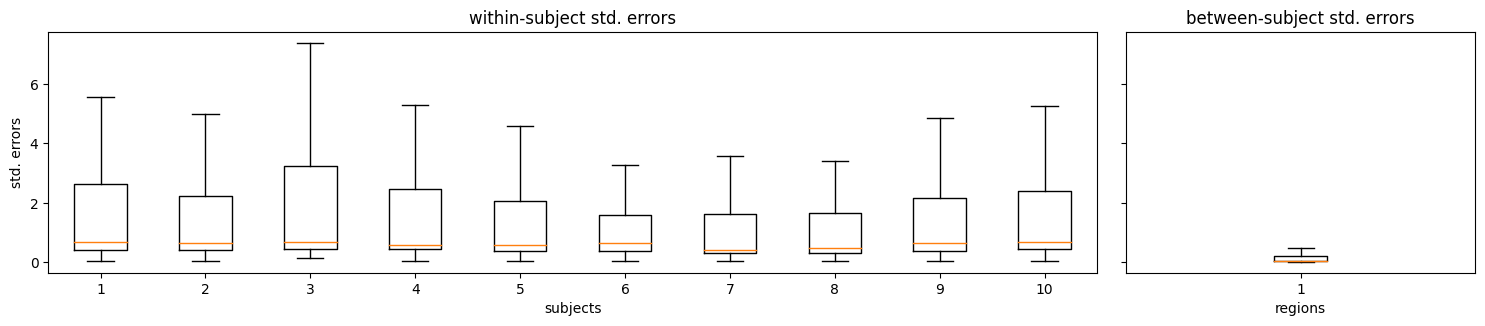

In [5]:
# compute the std. error of the timescales across subjects
region_stderrs = [sem(region) for region in zip(*timescales)]

fig, ax = plt.subplots(
    1, 2, figsize=(15, 3), sharey=True, gridspec_kw=dict(width_ratios=[0.75, 0.25])
)
fig.tight_layout(w_pad=0.5)
ax[0].boxplot(timescales, showfliers=False)
ax[0].set_title("within-subject std. errors")
ax[0].set_xlabel("subjects")
ax[0].set_ylabel("std. errors")

ax[1].boxplot(region_stderrs, showfliers=False)
ax[1].set_title("between-subject std. errors")
ax[1].set_xlabel("regions")
